In [52]:
import itertools
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression as MI
from scipy import stats as st

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 1. Joint exponentials

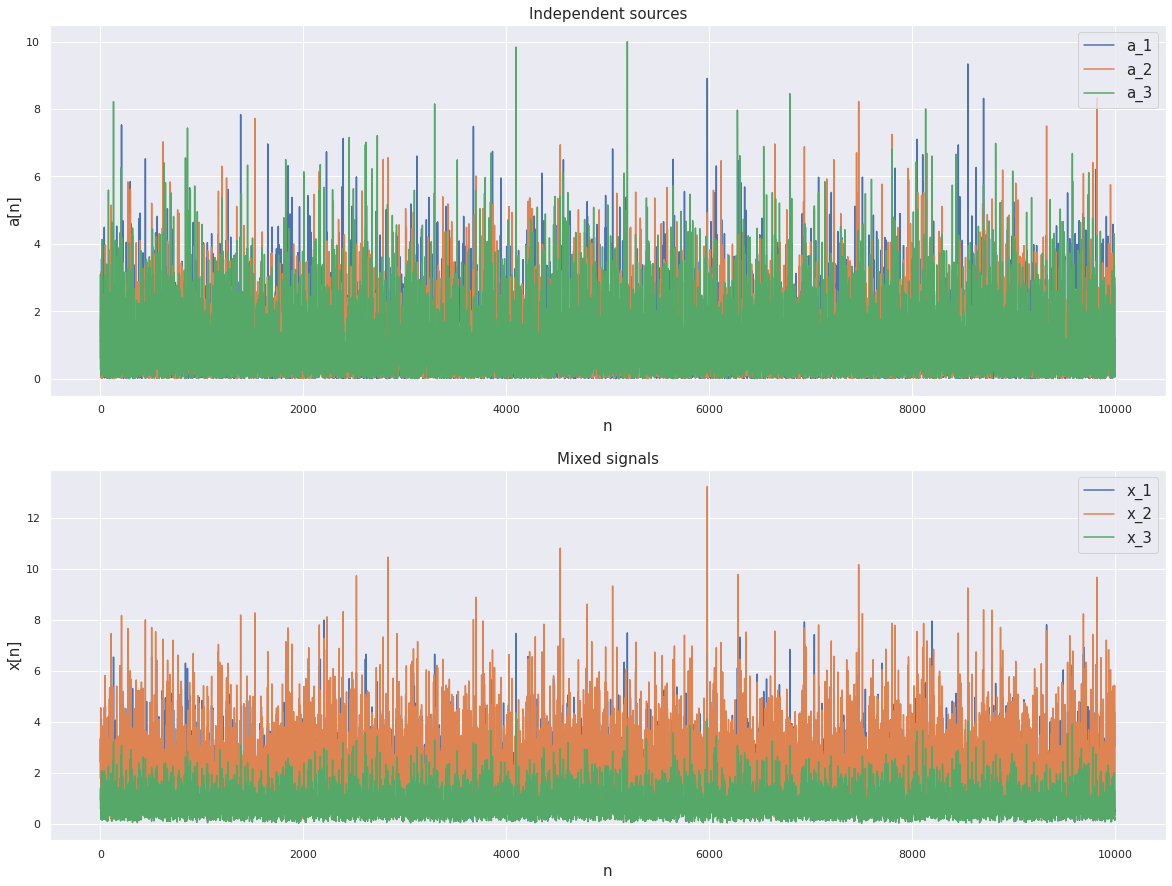

In [67]:
# Signal size
N=10000

# Number of independent sources
K=3

# Individual exponential rates
Lamb = np.array([
    1 for k in range(K)
])

# Generate sources
a = np.empty(
    shape=(K,N)
)
for k in range(K):
    a[k,:] = np.random.exponential(
        scale=1/Lamb[k],
        size=N
    )

# Mixing matrix
H = np.random.uniform(
    0,
    1,
    size=(K,K)
)

# Get mixed signals
x = H@a

# Plot signals
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20, 15)
)
for i in range(1,K+1):
    ax1.plot(
        range(N),
        a[i-1,:],
        label='a_{}'.format(i)
    )
    ax2.plot(
        range(N),
        x[i-1,:],
        label='x_{}'.format(i)
    )
    
ax1.set_xlabel('n', fontsize=15)
ax2.set_xlabel('n', fontsize=15)

ax1.set_ylabel('a[n]', fontsize=15)
ax2.set_ylabel('x[n]', fontsize=15)

ax1.set_title('Independent sources', fontsize=15)
ax2.set_title('Mixed signals', fontsize=15)
    
ax1.legend(loc='upper right', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)

# 2. Find optimal H

### 2.1. Random initialization

In [80]:
# Initialize random H
H_est=np.random.uniform(
    0,
    2,
    size=(K,K)
)

# Iterate to find optimal W
n_it=1000
learning_rate=1E-8
logs = pd.DataFrame()
combinations = [t for t in itertools.combinations(
    range(1,K+1),
    2
)]
for k in tqdm(range(1, n_it+1)):
    y=np.linalg.inv(H_est)@x
    det_H = np.linalg.det(H_est)
    adj_H = np.linalg.inv(H_est)*det_H
    delta_H=np.zeros((K,K))
    for i,j in np.ndindex((K,K)):
        delta_H[i,j] = - N*np.sign(det_H)*adj_H[j,i]/np.abs(det_H) - np.sum(x[j,:])*Lamb[i]
        

    # Update model of H
    H_est = H_est - learning_rate*delta_H
    
    # Update logs matrix
    logs_update = pd.DataFrame(
        index=[0],
        data={
            'it': [k],
            'gradient_magnitude': np.sum(np.abs(delta_H))
        }
    )
    for c in combinations:
        logs_update['mutual_info_{}{}'.format(c[0], c[1])] = MI(
            y.T, y.T[:,c[1]-1]
        )[c[0]-1]
    
    logs = pd.concat(
        [
            logs,
            logs_update
        ],
        axis=0
    )
    
print('-'*100)
print('Original H:\n{}'.format(H))
print('Estimated H:\n{}'.format(H_est))
print('-'*100)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [05:46<00:00,  2.89it/s]

----------------------------------------------------------------------------------------------------
Original H:
[[0.21326563 0.76529316 0.68141398]
 [0.9392548  0.94521005 0.14696946]
 [0.37884575 0.04149553 0.35093958]]
Estimated H:
[[1.60893015 1.61179119 0.12423502]
 [0.77631898 0.9002396  1.54155485]
 [0.82224374 1.62810885 0.42656756]]
----------------------------------------------------------------------------------------------------


Text(0.5, 0, 'iteration')

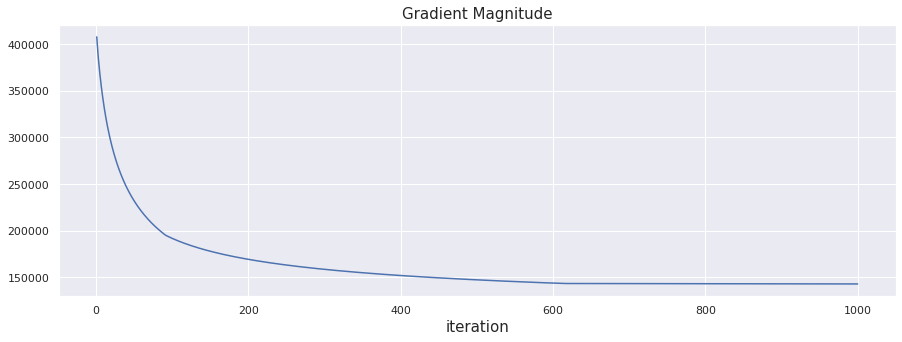

In [81]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.gradient_magnitude
)
plt.title('Gradient Magnitude', fontsize=15)
plt.xlabel('iteration', fontsize=15)

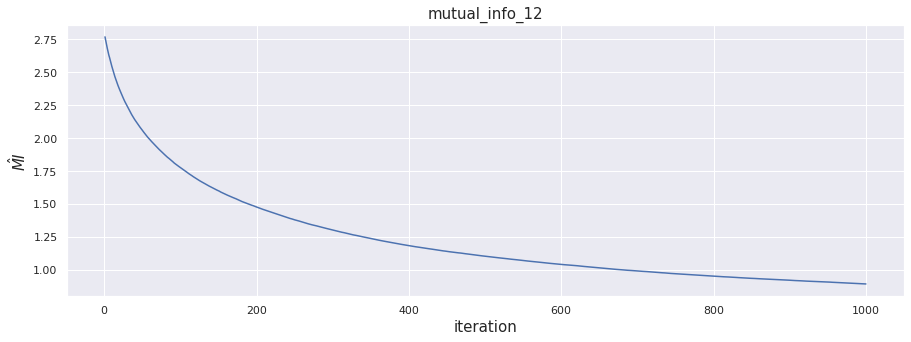

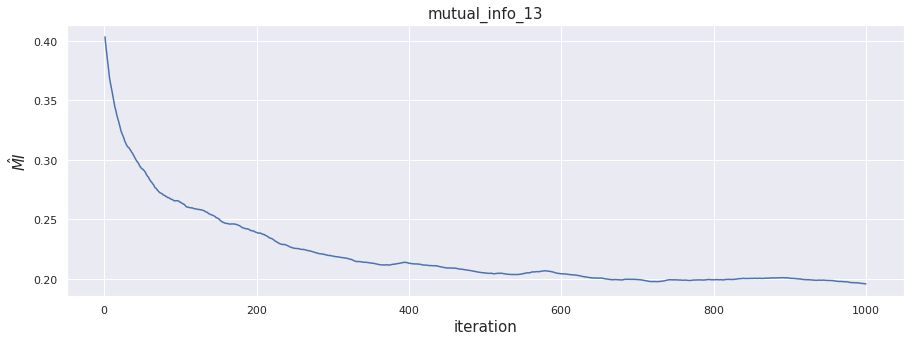

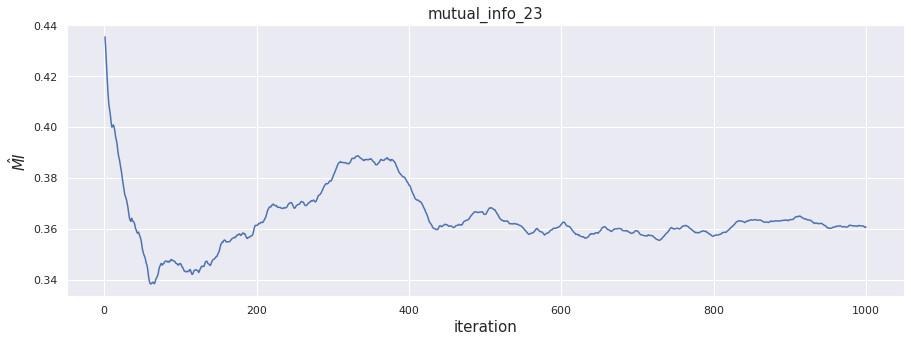

In [82]:
# Plot mutual info
for c in [col for col in logs.columns if 'mutual_info' in col]:
    fig = plt.figure(figsize=((15,5)))
    plt.plot(
        logs.it,
        logs[c]
    )
    plt.title(c, fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

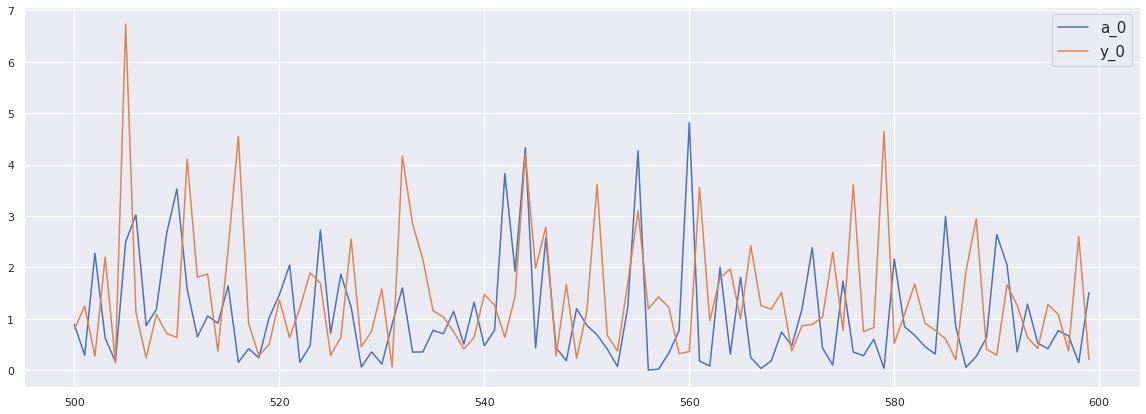

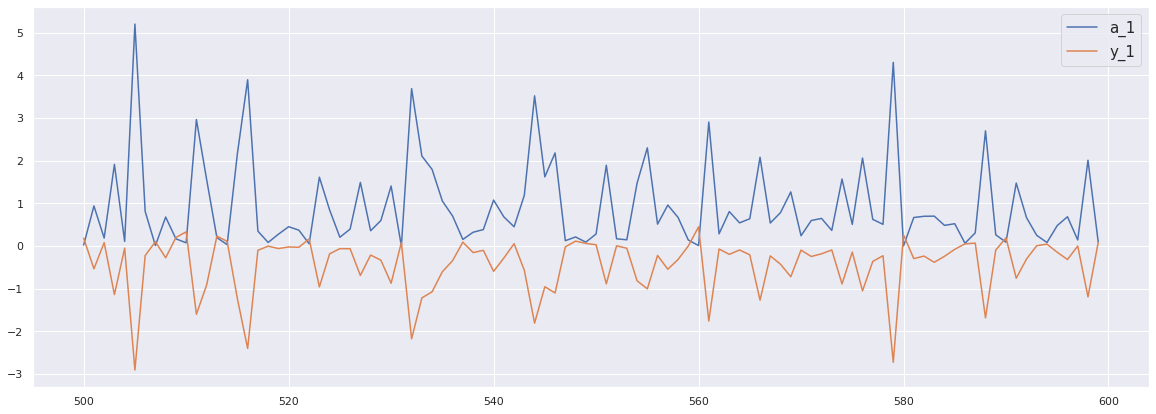

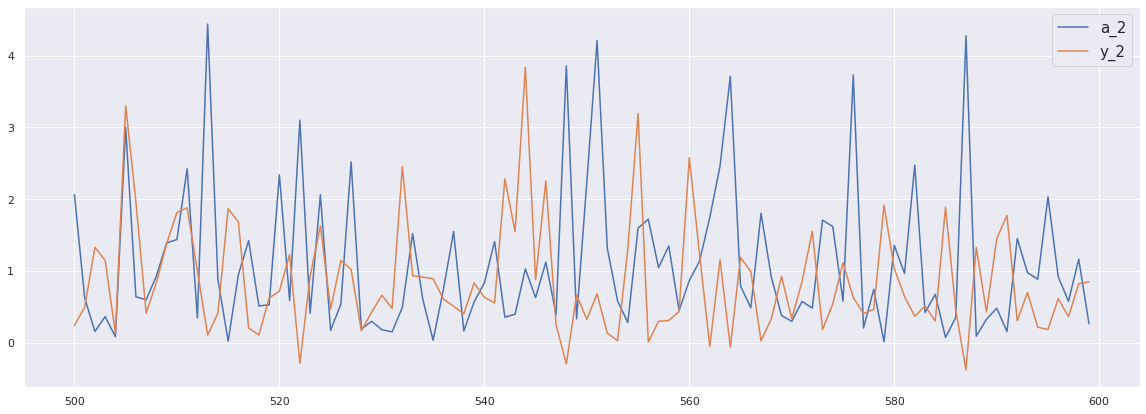

In [83]:
# Plot retrieved sources
y=np.linalg.inv(H_est)@x
START_PLOT=500
END_PLOT=600

for k in range(K):
    fig = plt.figure(figsize=(20,7))
    plt.plot(
        range(START_PLOT,END_PLOT),
        a[k,START_PLOT:END_PLOT],
        label='a_{}'.format(k)
    )
    plt.plot(
        range(START_PLOT,END_PLOT),
        y[k,START_PLOT:END_PLOT],
        label='y_{}'.format(k)
    )
    plt.legend(fontsize=15,loc='upper right')

### 2.2. Identity initialization

In [94]:
# Initialize random H
H_est=np.eye(
    N=K
)

# Iterate to find optimal W
n_it=1000
learning_rate=1E-8
logs = pd.DataFrame()
combinations = [t for t in itertools.combinations(
    range(1,K+1),
    2
)]
for k in tqdm(range(1, n_it+1)):
    y=np.linalg.inv(H_est)@x
    det_H = np.linalg.det(H_est)
    adj_H = np.linalg.inv(H_est)*det_H
    delta_H=np.zeros((K,K))
    for i,j in np.ndindex((K,K)):
        delta_H[i,j] = - N*np.sign(det_H)*adj_H[j,i]/np.abs(det_H) - np.sum(x[j,:])*Lamb[i]
        

    # Update model of H
    H_est = H_est - learning_rate*delta_H
    
    # Update logs matrix
    logs_update = pd.DataFrame(
        index=[0],
        data={
            'it': [k],
            'gradient_magnitude': np.sum(np.abs(delta_H))
        }
    )
    for c in combinations:
        logs_update['mutual_info_{}{}'.format(c[0], c[1])] = MI(
            y.T, y.T[:,c[1]-1]
        )[c[0]-1]
    
    logs = pd.concat(
        [
            logs,
            logs_update
        ],
        axis=0
    )
    
print('-'*100)
print('Original H:\n{}'.format(H))
print('Estimated H:\n{}'.format(H_est))
print('-'*100)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [05:47<00:00,  2.88it/s]

----------------------------------------------------------------------------------------------------
Original H:
[[0.21326563 0.76529316 0.68141398]
 [0.9392548  0.94521005 0.14696946]
 [0.37884575 0.04149553 0.35093958]]
Estimated H:
[[1.25623747 0.19678766 0.07180278]
 [0.15952549 1.29097206 0.07054546]
 [0.1639094  0.19991424 1.17035996]]
----------------------------------------------------------------------------------------------------


Text(0.5, 0, 'iteration')

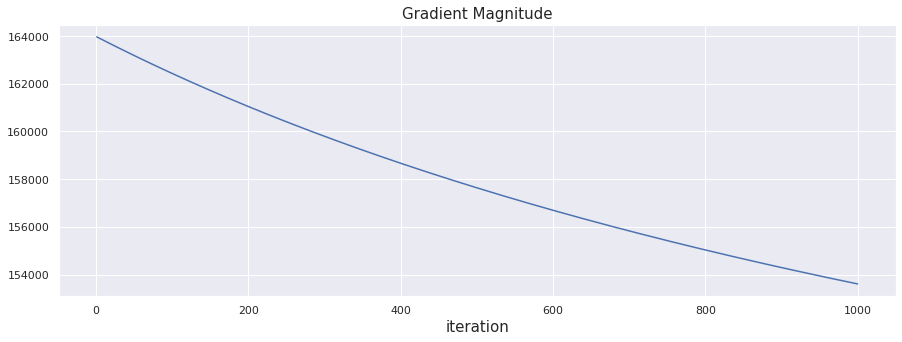

In [95]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.gradient_magnitude
)
plt.title('Gradient Magnitude', fontsize=15)
plt.xlabel('iteration', fontsize=15)

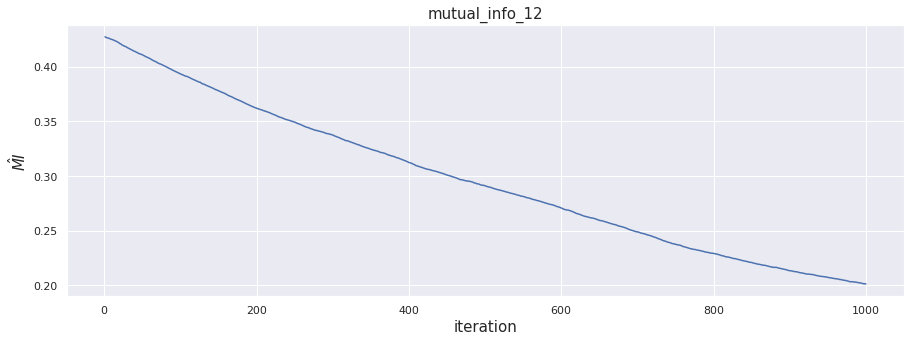

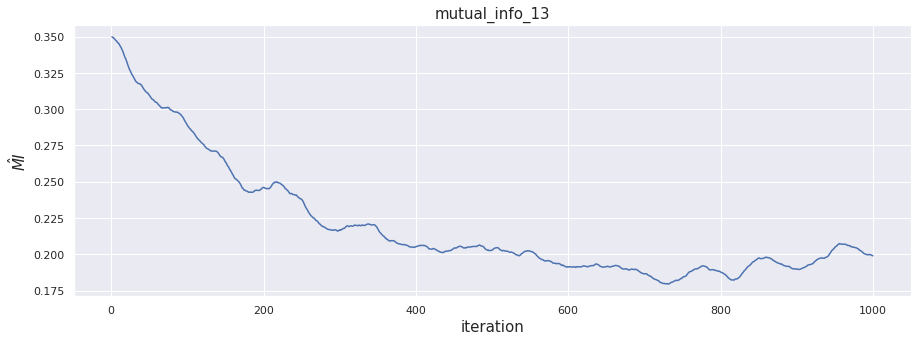

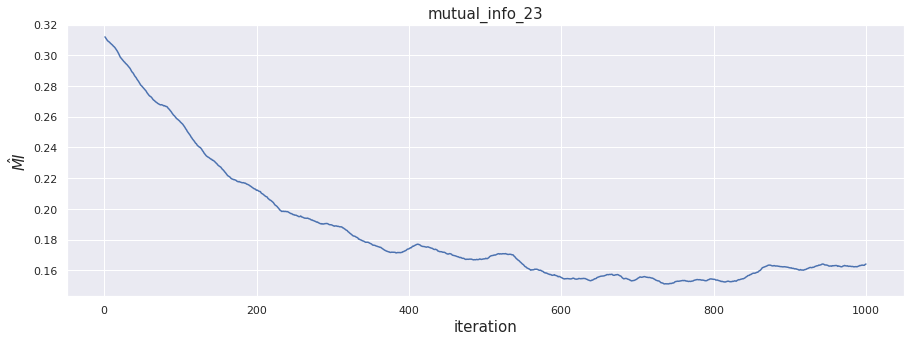

In [96]:
# Plot mutual info
for c in [col for col in logs.columns if 'mutual_info' in col]:
    fig = plt.figure(figsize=((15,5)))
    plt.plot(
        logs.it,
        logs[c]
    )
    plt.title(c, fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

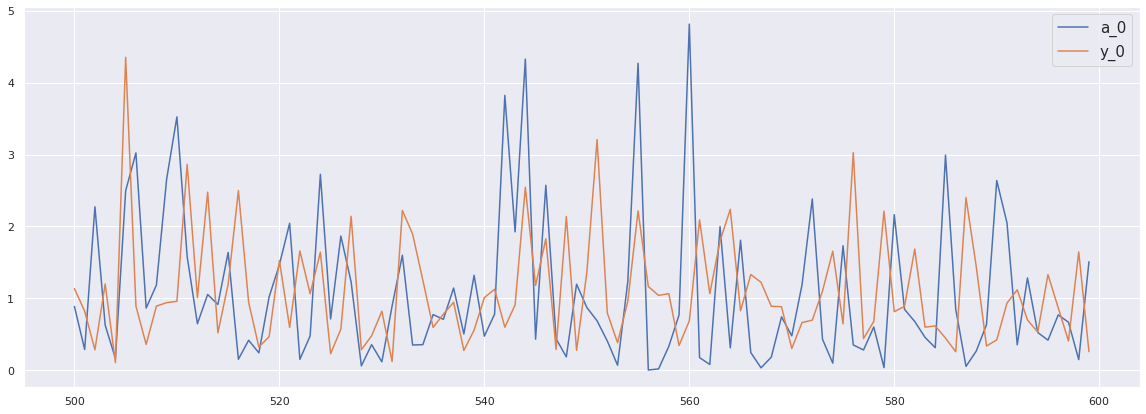

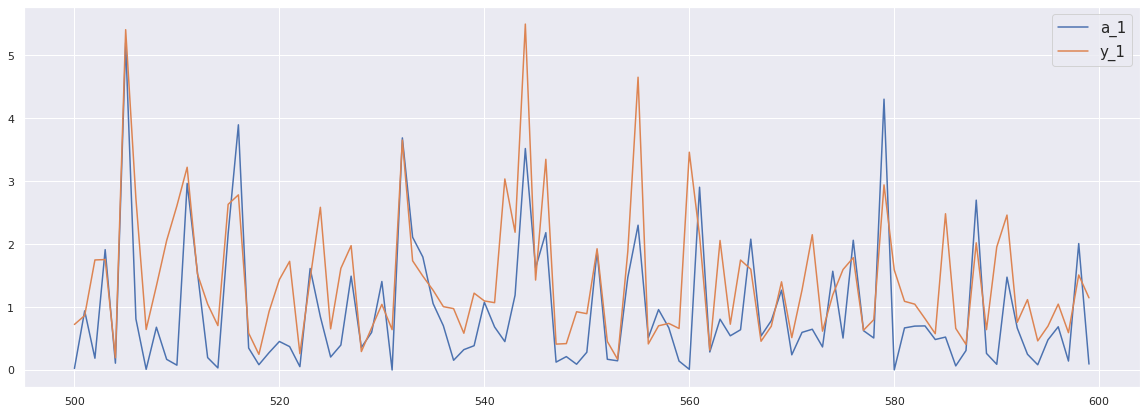

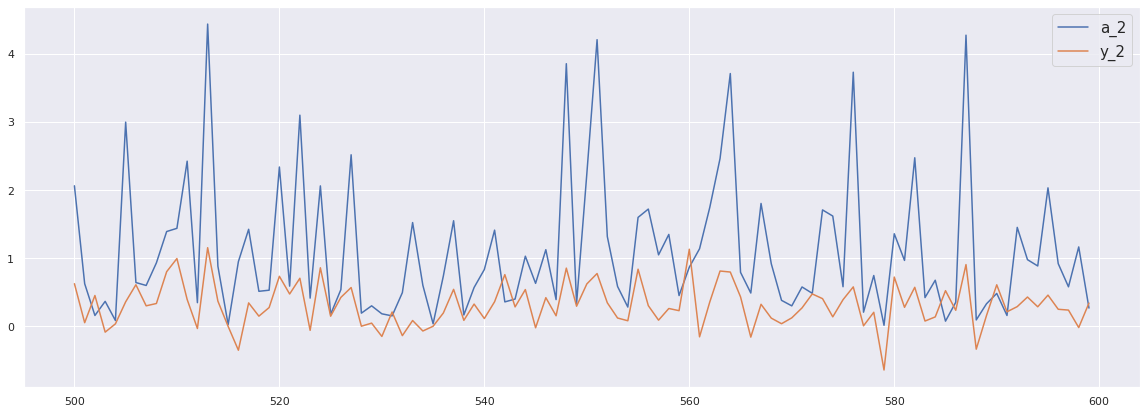

In [97]:
# Plot retrieved sources
y=np.linalg.inv(H_est)@x
START_PLOT=500
END_PLOT=600

for k in range(K):
    fig = plt.figure(figsize=(20,7))
    plt.plot(
        range(START_PLOT,END_PLOT),
        a[k,START_PLOT:END_PLOT],
        label='a_{}'.format(k)
    )
    plt.plot(
        range(START_PLOT,END_PLOT),
        y[k,START_PLOT:END_PLOT],
        label='y_{}'.format(k)
    )
    plt.legend(fontsize=15,loc='upper right')